In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display

df=pd.read_csv('~/code/fablaw/circor/raw_data/1.0.3/best_table.csv')
df

,patient_id,select,audible,outcome
0,2530,TV,TV,1
1,9979,PV,TV,1
2,13918,AV,TV,1
3,14241,PV,PV,1
4,14998,PV,PV,1
...,...,...,...,...
516,85337,MV,MV,0
517,85338,PV,PV,0
518,85340,MV,MV,0
519,85341,PV,PV,0


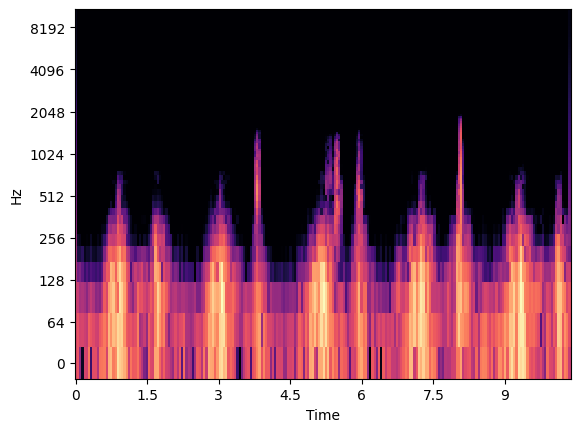

In [2]:
for i in df.index:
    file='../raw_data/1.0.3/audio_treated/'+str(df.loc[i, 'patient_id'])+'_'+df.loc[i,'audible']+'.wav'
    x, sr=librosa.load(file)
    
    D = librosa.stft(x[0:50000], n_fft=446, hop_length=224)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    
    spectrogram = librosa.display.specshow(S_db, y_axis="log", sr=sr, hop_length=1024, x_axis="time")
    
    rgbas= spectrogram.to_rgba(spectrogram.get_array().reshape(S_db.shape))
    
    rgba=rgbas[:,:,0:3]
    
    output='/Users/fabianlaw/code/fablaw/circor/raw_data/1.0.3/proc_img_treated/'+str(df.loc[i, 'patient_id'])+'_'+df.loc[i,'audible']+'.npy'
    np.save(output, rgba)

In [3]:
X_raw=[]
for i in df.index:
    file='../raw_data/1.0.3/proc_img_treated/'+str(df.loc[i,'patient_id'])+'_'+df.loc[i,'audible']+'.npy'
    v=np.load(file)
    X_raw.append(v)
    
X=np.stack(X_raw)

In [4]:
X.shape[1:]

(224, 224, 3)

In [5]:
y=df.outcome

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=1)

In [7]:
from tensorflow.keras.layers import Dense, Flatten, MaxPool1D, Conv1D, LSTM, BatchNormalization, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.metrics import Recall

import matplotlib.pyplot as plt

In [8]:
base_model = DenseNet201(include_top=False, input_shape=(224, 224, 3))

In [9]:
base_model.trainable = False

In [10]:
layer1=Flatten()
layer2=Dense(2048, activation='relu')
layer3=Dense(1024, activation='relu')
layer4=Dense(512, activation='relu')
layer5=Dense(256, activation='relu')
layer6=Dense(128, activation='relu')
layer7=Dense(64, activation='relu')
layer8=Dense(32, activation='relu')
layer9=Dense(16, activation='relu')
layer10=Dense(8, activation='relu')
layer11=Dense(1, activation='sigmoid')

In [11]:
model = Sequential([base_model, layer1, layer2, layer3, layer4, layer5, layer6, layer7, layer8, layer9, layer10, layer11])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 94080)             0         
                                                                 
 dense (Dense)               (None, 2048)              192677888 
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 128)               3

In [13]:
model.compile(loss=BinaryCrossentropy(),
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy', Recall()])

In [14]:
es=EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy')
history=model.fit(X_train, y_train, 
                  validation_split=0.2, 
                  batch_size=32, 
                  epochs=50, 
                  callbacks=[es])

Epoch 1/50


/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]
2022-12-05 10:58:40.736383: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


10/10 [==============================] - 36s 3s/step - loss: 0.7134 - accuracy: 0.4570 - recall: 0.8618 - val_loss: 0.6930 - val_accuracy: 0.5205 - val_recall: 0.5122
Epoch 2/50
10/10 [==============================] - 26s 3s/step - loss: 0.6833 - accuracy: 0.5842 - recall: 0.0976 - val_loss: 0.7291 - val_accuracy: 0.4384 - val_recall: 0.0000e+00
Epoch 3/50
10/10 [==============================] - 30s 3s/step - loss: 0.6903 - accuracy: 0.5567 - recall: 0.1707 - val_loss: 0.7778 - val_accuracy: 0.4384 - val_recall: 0.0000e+00
Epoch 4/50
10/10 [==============================] - 29s 3s/step - loss: 0.6929 - accuracy: 0.5773 - recall: 0.0000e+00 - val_loss: 0.7356 - val_accuracy: 0.4384 - val_recall: 0.0000e+00
Epoch 5/50
10/10 [==============================] - 28s 3s/step - loss: 0.7169 - accuracy: 0.5189 - recall: 0.4390 - val_loss: 0.7075 - val_accuracy: 0.4384 - val_recall: 0.0000e+00
Epoch 6/50
10/10 [==============================] - 28s 3s/step - loss: 0.6827 - accuracy: 0.5773 - r

In [15]:
def plot_loss_recall(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(ymin=0, ymax=3)
    ax1.legend(['Train', 'Validation'], loc='best')
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)    

    
    ax2.plot(history.history['recall'])
    ax2.plot(history.history['val_recall'])
    ax2.set_title('Recall')
    ax2.set_ylabel('Recall')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(ymin=0, ymax=1)
    ax2.legend(['Train', 'Validation'], loc='best')
    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)    

    plt.show()

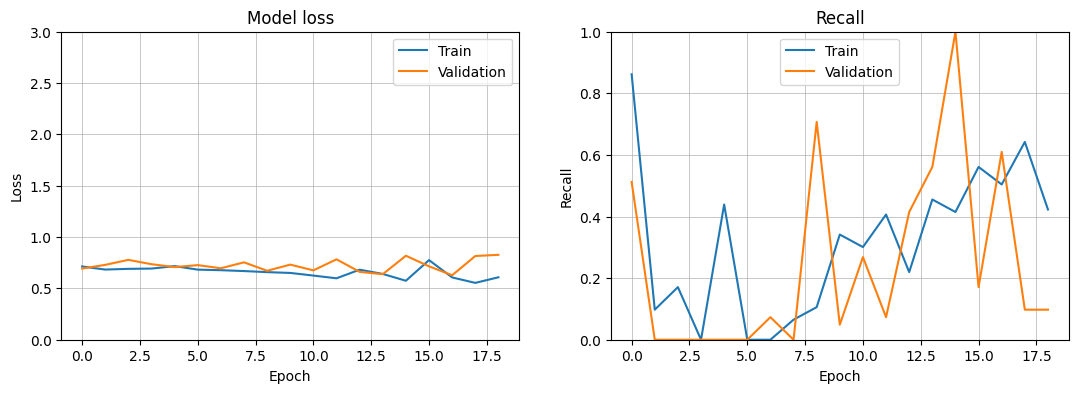

In [16]:
plot_loss_recall(history)

In [17]:
es.best_epoch

8

In [18]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 8s 2s/step - loss: 0.6803 - accuracy: 0.5541 - recall: 0.5467


[0.6802904009819031, 0.5541401505470276, 0.54666668176651]

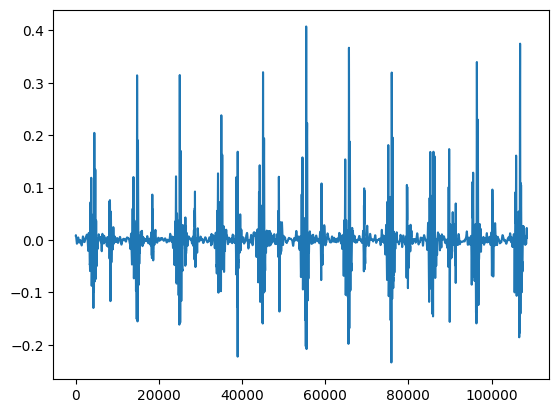

In [19]:
plt.plot(x)

In [20]:
X_test[0,:,:,:]

array([[[7.09962e-01, 2.12797e-01, 4.77201e-01],
        [9.71582e-01, 4.54210e-01, 3.61030e-01],
        [9.90871e-01, 5.72706e-01, 3.98714e-01],
        ...,
        [9.95480e-01, 6.39027e-01, 4.36607e-01],
        [9.55849e-01, 4.04400e-01, 3.60619e-01],
        [9.95932e-01, 8.05527e-01, 5.66202e-01]],

       [[8.16914e-01, 2.55895e-01, 4.36461e-01],
        [9.73381e-01, 4.61520e-01, 3.61965e-01],
        [9.92785e-01, 5.94891e-01, 4.10283e-01],
        ...,
        [9.96727e-01, 7.76795e-01, 5.41039e-01],
        [9.95810e-01, 6.46344e-01, 4.41361e-01],
        [9.96369e-01, 7.91167e-01, 5.53499e-01]],

       [[8.40636e-01, 2.68953e-01, 4.24666e-01],
        [9.33606e-01, 3.58764e-01, 3.70541e-01],
        [9.75082e-01, 4.68861e-01, 3.63111e-01],
        ...,
        [9.94222e-01, 8.48540e-01, 6.05696e-01],
        [9.97019e-01, 7.62398e-01, 5.28821e-01],
        [9.97351e-01, 7.19089e-01, 4.93755e-01]],

       ...,

       [[4.38300e-02, 3.38300e-02, 1.41886e-01],
        [1.

In [21]:
model.predict(X_test).shape

5/5 [==============================] - 9s 2s/step


(157, 1)

In [22]:
X_test.shape

(157, 224, 224, 3)

In [23]:
X_test[0].shape

(224, 224, 3)

In [24]:
model.predict(X_test[0:2])

1/1 [==============================] - 0s 172ms/step


array([[0.512506  ],
       [0.57831967]], dtype=float32)

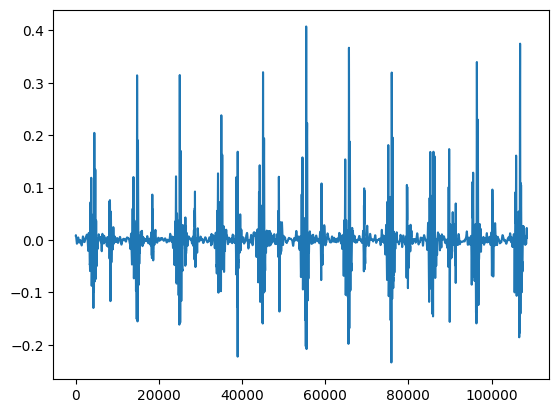

In [25]:
plt.plot(x)

In [26]:
y=[]
for i in range(0,18000):
    y.append(abs(x[i+1]-x[i]))
y

[0.00083612,
 0.0004560072,
 9.727571e-05,
 0.00018930435,
 0.00036972854,
 0.00043199677,
 0.00038671587,
 0.00026314426,
 0.000101720914,
 5.516084e-05,
 0.0001720367,
 0.00022702804,
 0.00021509267,
 0.00014713686,
 4.5985915e-05,
 6.028544e-05,
 0.00014530402,
 0.00019054022,
 0.00018891133,
 0.00014547491,
 7.509347e-05,
 2.0158477e-06,
 6.5702014e-05,
 0.00010082591,
 0.00010060333,
 6.7668036e-05,
 1.2646429e-05,
 4.901644e-05,
 0.00010135956,
 0.0001319074,
 0.00013460079,
 0.00011089584,
 6.886339e-05,
 2.0741485e-05,
 2.047373e-05,
 4.4394284e-05,
 4.570419e-05,
 2.5236513e-05,
 1.0635238e-05,
 5.1955692e-05,
 8.796016e-05,
 0.000109879766,
 0.00011309888,
 9.808503e-05,
 7.000612e-05,
 3.7089456e-05,
 8.384697e-06,
 8.677598e-06,
 1.0077376e-05,
 3.9162114e-06,
 2.9057264e-05,
 5.8436766e-05,
 8.440716e-05,
 0.00010061078,
 0.000103573315,
 9.342795e-05,
 7.371511e-05,
 5.0279312e-05,
 2.9608142e-05,
 1.715729e-05,
 1.5941449e-05,
 2.5894493e-05,
 4.4037122e-05,
 6.541377e-0

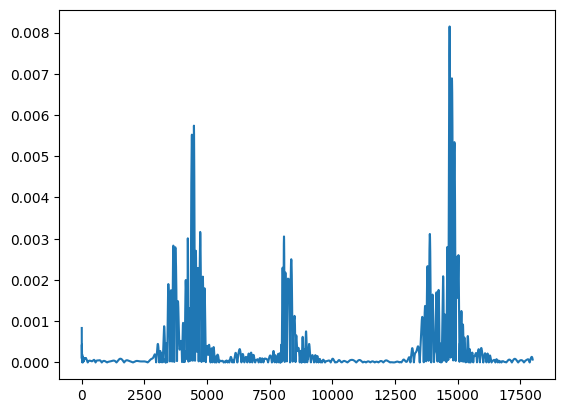

In [27]:
plt.plot(y)

In [39]:
file_new='../raw_data/1.0.3/proc_img_treated/24160_TV.npy'
X_new=np.load(file_new)
X_new

array([[[9.73381e-01, 4.61520e-01, 3.61965e-01],
        [9.91558e-01, 5.80107e-01, 4.02441e-01],
        [9.17689e-01, 3.35500e-01, 3.79915e-01],
        ...,
        [9.92785e-01, 5.94891e-01, 4.10283e-01],
        [9.86700e-01, 5.35582e-01, 3.82210e-01],
        [9.93326e-01, 6.02275e-01, 4.14390e-01]],

       [[9.60949e-01, 4.18323e-01, 3.59630e-01],
        [9.73381e-01, 4.61520e-01, 3.61965e-01],
        [9.69680e-01, 4.46936e-01, 3.60311e-01],
        ...,
        [9.53099e-01, 3.97563e-01, 3.61438e-01],
        [9.97228e-01, 7.47981e-01, 5.16859e-01],
        [9.90871e-01, 5.72706e-01, 3.98714e-01]],

       [[8.99552e-01, 3.14616e-01, 3.91037e-01],
        [6.39216e-01, 1.89921e-01, 4.94150e-01],
        [8.68793e-01, 2.87728e-01, 4.09303e-01],
        ...,
        [9.90138e-01, 5.65296e-01, 3.95122e-01],
        [9.95131e-01, 8.27052e-01, 5.85701e-01],
        [9.73381e-01, 4.61520e-01, 3.61965e-01]],

       ...,

       [[1.13094e-01, 6.54920e-02, 2.76784e-01],
        [1.

In [40]:
X_new.shape

(224, 224, 3)

In [41]:
model.predict(X_new)

InvalidArgumentError: Graph execution error:

Detected at node 'sequential/densenet201/zero_padding2d/Pad' defined at (most recent call last):
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/traitlets/config/application.py", line 982, in launch_instance
      app.start()
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/79/3v_6vhfj41sgvtvln59h7l_00000gn/T/ipykernel_23021/4260267409.py", line 1, in <module>
      model.predict(X_new)
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/keras/engine/training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/keras/engine/training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/keras/engine/training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/keras/engine/training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/keras/engine/training.py", line 1983, in predict_step
      return self(x, training=False)
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/keras/engine/sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/keras/layers/reshaping/zero_padding2d.py", line 149, in call
      return backend.spatial_2d_padding(
    File "/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/keras/backend.py", line 4031, in spatial_2d_padding
      return tf.compat.v1.pad(x, pattern)
Node: 'sequential/densenet201/zero_padding2d/Pad'
The first dimension of paddings must be the rank of inputs[4,2] [32,224,3]
	 [[{{node sequential/densenet201/zero_padding2d/Pad}}]] [Op:__inference_predict_function_55801]

In [44]:
model.predict(X_new.reshape((1,224,224,3)))

1/1 [==============================] - 0s 125ms/step


array([[0.5107186]], dtype=float32)